# Análisis de Linealidad QHY174M-GPS



In [1]:
# Imports
import os
from astropy import units as u
from astropy.nddata import CCDData, Cutout2D
from astropy.io import fits
from astropy.visualization import (PercentileInterval, LinearStretch, ImageNormalize)
import ccdproc 
import numpy as np
import pandas as pd
from scipy import stats
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import StrMethodFormatter, NullFormatter
from itertools import compress
import warnings
warnings.filterwarnings('ignore')

# Defines
bias_dir = "Bias/"
dark_dir = "Dark/"
flat_dir = "Flat/"
masters_dir = "Masters/"

def get_best_dark_exp_time(raw_exp_time,darks_exptimes):
    # Given a raw image exposure time and the available dark images exposure time gets the best dark exposure time to be used to
    # calibrate raw images. The selected dark eposute time is is the one that has to be scaled (multipling if less than 
    # raw_exp_time or dividing if greater thatan raw_exp_time) the least number of times. As example if raw_exp_time = 4 and 
    # darks_exptimes = [1 10], the otput wil be 10, due to 1s dark images must be scaled (multiplied) 4 times, and 10s dark 
    # must be scaled (multiplied) 4 times.
    # Iputs:
    #     - raw_exp_time (float), raw images exposure times
    #     - darks_exptimes (list of floats), list of exposure times of avaliable dark images.
    # Output:
    #     - best_exp_time (float), exposure time of image with lower scaling factor.
    darks_exptimes = sorted(darks_exptimes)
    factor = [(raw_exp_time/i if (raw_exp_time/i>=1) else i/raw_exp_time) for i in darks_exptimes]
    best_exp_time = darks_exptimes[factor.index(min(factor))]
    return(best_exp_time)

## 1. Generación de Master Bias

* Se cargas las imágenes bias desde el directorio bias_dir.
* Se combinan las imágenes.
* Se guarda el master bias.

In [2]:
# Bias images loading
bias = ccdproc.ImageFileCollection(bias_dir)
bias.summary

<Table masked=True length=10>
            file             simple bitpix ... notes flipstat    swowner    
           str28              bool  int32  ...  str1   str1       str14     
---------------------------- ------ ------ ... ----- -------- --------------
QHY174M_B50-G0-0001-Bias.fit   True     16 ...                Tan Yong Liang
QHY174M_B50-G0-0002-Bias.fit   True     16 ...                Tan Yong Liang
QHY174M_B50-G0-0003-Bias.fit   True     16 ...                Tan Yong Liang
QHY174M_B50-G0-0004-Bias.fit   True     16 ...                Tan Yong Liang
QHY174M_B50-G0-0005-Bias.fit   True     16 ...                Tan Yong Liang
QHY174M_B50-G0-0006-Bias.fit   True     16 ...                Tan Yong Liang
QHY174M_B50-G0-0007-Bias.fit   True     16 ...                Tan Yong Liang
QHY174M_B50-G0-0008-Bias.fit   True     16 ...                Tan Yong Liang
QHY174M_B50-G0-0009-Bias.fit   True     16 ...                Tan Yong Liang
QHY174M_B50-G0-0010-Bias.fit   True     16 ...                Tan Yong Liang

In [3]:
# Master bias generation
bias = bias.filter(imagetyp = 'Bias Frame')
master_bias = ccdproc.combine(bias.files,
                              unit=u.adu,
                              method='median',
                              sigma_clip=True,
                              sigma_clip_low_thresh=3,
                              sigma_clip_high_thresh=3,
                              sigma_clip_func=np.ma.median)

master_bias.meta['combined'] = True

# Master bias save
master_bias.write(masters_dir + 'master_bias.fits', overwrite=True)
master_bias.header

SIMPLE  =                    T                                                  
BITPIX  =                   16 /8 unsigned int, 16 & 32 int, -32 & -64 real     
NAXIS   =                    2 /number of axes                                  
NAXIS1  =                 1920 /fastest changing axis                           
NAXIS2  =                 1200 /next to fastest changing axis                   
BSCALE  =   1.0000000000000000 /physical = BZERO + BSCALE*array_value           
BZERO   =   32768.000000000000 /physical = BZERO + BSCALE*array_value           
DATE-OBS= '2021-10-31T23:48:28.11' /YYYY-MM-DDThh:mm:ss observation start, UT   
EXPTIME =  0.00000000000000000 /Exposure time in seconds                        
EXPOSURE=  0.00000000000000000 /Exposure time in seconds                        
SET-TEMP=  0.00000000000000000 /CCD temperature setpoint in C                   
CCD-TEMP= -0.10000000000000001 /CCD temperature at start of exposure in C       
XPIXSZ  =   5.86000000000000

## 2. Generación de Masters Dark

* Se cargan las imágenes bias desde el directorio dark_dir.
* Se mestran los tiempos de explosición para los que se dispone de darks.
* Para cada tiempo de exposición,
    * se corrige el bias en el los darks, 
    * se cobinan las imágenes para obtener el master y
    * se almacena el master.

In [4]:
# Dark images loading
darks = ccdproc.ImageFileCollection(dark_dir)
darks.summary

<Table masked=True length=30>
              file               simple bitpix ... notes flipstat    swowner    
             str32                bool  int32  ...  str1   str1       str14     
-------------------------------- ------ ------ ... ----- -------- --------------
QHY174M_B50-G0-0001-Dark-10s.fit   True     16 ...                Tan Yong Liang
 QHY174M_B50-G0-0001-Dark-1s.fit   True     16 ...                Tan Yong Liang
QHY174M_B50-G0-0001-Dark-20s.fit   True     16 ...                Tan Yong Liang
QHY174M_B50-G0-0002-Dark-10s.fit   True     16 ...                Tan Yong Liang
 QHY174M_B50-G0-0002-Dark-1s.fit   True     16 ...                Tan Yong Liang
QHY174M_B50-G0-0002-Dark-20s.fit   True     16 ...                Tan Yong Liang
QHY174M_B50-G0-0003-Dark-10s.fit   True     16 ...                Tan Yong Liang
 QHY174M_B50-G0-0003-Dark-1s.fit   True     16 ...                Tan Yong Liang
QHY174M_B50-G0-0003-Dark-20s.fit   True     16 ...                Tan Yong Liang
QHY174M_B50-G0-0004-Dark-10s.fit   True     16 ...                Tan Yong Liang
                             ...    ...    ... ...   ...      ...            ...
QHY174M_B50-G0-0007-Dark-20s.fit   True     16 ...                Tan Yong Liang
QHY174M_B50-G0-0008-Dark-10s.fit   True     16 ...                Tan Yong Liang
 QHY174M_B50-G0-0008-Dark-1s.fit   True     16 ...                Tan Yong Liang
QHY174M_B50-G0-0008-Dark-20s.fit   True     16 ...                Tan Yong Liang
QHY174M_B50-G0-0009-Dark-10s.fit   True     16 ...                Tan Yong Liang
 QHY174M_B50-G0-0009-Dark-1s.fit   True     16 ...                Tan Yong Liang
QHY174M_B50-G0-0009-Dark-20s.fit   True     16 ...                Tan Yong Liang
QHY174M_B50-G0-0010-Dark-10s.fit   True     16 ...                Tan Yong Liang
 QHY174M_B50-G0-0010-Dark-1s.fit   True     16 ...                Tan Yong Liang
QHY174M_B50-G0-0010-Dark-20s.fit   True     16 ...                Tan Yong Liang

In [5]:
# Print exposure times of available dark images
texp_darks = darks.values('exptime', unique=True)
print('Darks exposure times:', texp_darks)

Darks exposure times: [1.0, 10.0, 20.0]


In [6]:
# Correct darks for bias

for exp_time in sorted(texp_darks):                             # For each exposure time                       
    print ('* Dark exposure time:', exp_time,'s')
    darks_group = darks.filter(exptime = exp_time)              # Filter for darks of current exposure time
    corrected_darks = [ccdproc.subtract_bias(ccd, master_bias)  # Bias correction
                       for ccd in darks_group.ccds(ccd_kwargs={'unit': u.adu})]
    
    combined_dark = ccdproc.combine(corrected_darks,            # Dark images conbination
                                    unit=u.adu,
                                    method='median',
                                    sigma_clip=True,
                                    sigma_clip_low_thresh=3,
                                    sigma_clip_high_thresh=3,
                                    sigma_clip_func=np.ma.median)
    
    combined_dark.meta['combined'] = True

    dark_file_name = 'master_dark_{:.3f}.fit'.format(exp_time)
    combined_dark.write(masters_dir + dark_file_name, overwrite=True)

* Dark exposure time: 1.0 s
* Dark exposure time: 10.0 s
* Dark exposure time: 20.0 s


## 3. Generacion de Masters Flat
* Se cargan las imágenes master bias y dark.
* Se cargan las imágenes flat
* Se mestran los tiempos de exposición de los flats
* Para cada tiempo de exposición,
  * Se carga el dark del tiempo de exposición que menos se debe escalar,
  * Se corrige el bias y dark en los flats,
  * se cobinan las imágenes para obtener el master y
  * se almacena el master.

In [7]:
# Master bias and dark loading
masters = ccdproc.ImageFileCollection(masters_dir)
masters.summary

<Table masked=True length=31>
         file          ...
        str22          ...
---------------------- ...
      master_bias.fits ...
 master_dark_1.000.fit ...
master_dark_10.000.fit ...
master_dark_20.000.fit ...
 master_flat_0.001.fit ...
 master_flat_0.010.fit ...
 master_flat_0.100.fit ...
 master_flat_0.500.fit ...
 master_flat_1.000.fit ...
master_flat_10.000.fit ...
                   ... ...
master_flat_21.000.fit ...
master_flat_22.000.fit ...
master_flat_23.000.fit ...
 master_flat_3.000.fit ...
 master_flat_4.000.fit ...
 master_flat_5.000.fit ...
 master_flat_6.000.fit ...
 master_flat_7.000.fit ...
 master_flat_8.000.fit ...
 master_flat_9.000.fit ...

In [8]:
# Flats loading
flats = ccdproc.ImageFileCollection(flat_dir)
flats.summary

<Table masked=True length=271>
              file              simple bitpix ... notes flipstat    swowner    
             str34               bool  int32  ...  str1   str1       str14     
------------------------------- ------ ------ ... ----- -------- --------------
QHY174M_B50-G0-0001-0p0001s.fit   True     16 ...                Tan Yong Liang
  QHY174M_B50-G0-0001-0p01s.fit   True     16 ...                Tan Yong Liang
   QHY174M_B50-G0-0001-0p1s.fit   True     16 ...                Tan Yong Liang
   QHY174M_B50-G0-0001-0p5s.fit   True     16 ...                Tan Yong Liang
    QHY174M_B50-G0-0001-10s.fit   True     16 ...                Tan Yong Liang
    QHY174M_B50-G0-0001-11s.fit   True     16 ...                Tan Yong Liang
    QHY174M_B50-G0-0001-12s.fit   True     16 ...                Tan Yong Liang
    QHY174M_B50-G0-0001-13s.fit   True     16 ...                Tan Yong Liang
    QHY174M_B50-G0-0001-14s.fit   True     16 ...                Tan Yong Liang
    QHY174M_B50-G0-0001-15s.fit   True     16 ...                Tan Yong Liang
                            ...    ...    ... ...   ...      ...            ...
    QHY174M_B50-G0-0010-22s.fit   True     16 ...                Tan Yong Liang
    QHY174M_B50-G0-0010-23s.fit   True     16 ...                Tan Yong Liang
     QHY174M_B50-G0-0010-2s.fit   True     16 ...                Tan Yong Liang
     QHY174M_B50-G0-0010-3s.fit   True     16 ...                Tan Yong Liang
     QHY174M_B50-G0-0010-4s.fit   True     16 ...                Tan Yong Liang
     QHY174M_B50-G0-0010-5s.fit   True     16 ...                Tan Yong Liang
     QHY174M_B50-G0-0010-6s.fit   True     16 ...                Tan Yong Liang
     QHY174M_B50-G0-0010-7s.fit   True     16 ...                Tan Yong Liang
     QHY174M_B50-G0-0010-8s.fit   True     16 ...                Tan Yong Liang
     QHY174M_B50-G0-0010-9s.fit   True     16 ...                Tan Yong Liang

In [9]:
# Print exposure times of flat images
texp_flats = sorted(flats.values('exptime', unique=True))
print('Flats exposure times:', texp_flats)

Flats exposure times: [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]


In [10]:
# Correct flats for bias, darks and generate masters

master_bias = CCDData.read(masters.files_filtered(imagetyp = 'Bias Frame', combined=True, include_path=True)[0], unit=u.adu)

for exp_time in sorted(texp_flats):                                # For each exposure time
    
    # Dark image loadig
    chosed_dark_texp = get_best_dark_exp_time(exp_time,texp_darks) # Chose the best darck exposure time
    scale_flag = chosed_dark_texp != exp_time                      # if true dark must be scaled
    master_dark = CCDData.read(masters.files_filtered(imagetyp = 'Dark Frame', exptime=chosed_dark_texp, combined=True, 
                                                      include_path=True)[0], unit=u.adu)
    
    print('* Flat exposure time = ', exp_time, 's')
    print('* Chosed exposure time = ', chosed_dark_texp, 's')
    print('* Must be scaled = ', scale_flag)

    flats_group = flats.filter(exptime = exp_time)                 # Filter for darks of current exposure time
    
    # Correct flats for bias
    corrected_flats = [ccdproc.subtract_bias(ccd, master_bias)     # Bias correction 
                       for ccd in flats_group.ccds(ccd_kwargs={'unit': u.adu})]

    corrected_flats = [ccdproc.subtract_dark(ccd, master_dark,    # Bias correction
                                             exposure_time='exptime',
                                             exposure_unit=u.second,
                                             scale=scale_flag)
                       for ccd in corrected_flats]

    master_flat = ccdproc.combine(corrected_flats,                 # Flat images conbination   
                              unit=u.adu,
                              method='median',
                              sigma_clip=True,
                              sigma_clip_low_thresh=3,
                              sigma_clip_high_thresh=3,
                              sigma_clip_func=np.ma.median)
                              #mem_limit=5e8)
    
    master_flat.meta['combined'] = True

    master_flat_name = 'master_flat_{:.3f}.fit'.format(exp_time)
    master_flat.write(masters_dir + master_flat_name, overwrite=True)

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
* Flat exposure time =  0.001 s
* Chosed exposure time =  1.0 s
* Must be scaled =  True


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
* Flat exposure time =  0.01 s
* Chosed exposure time =  1.0 s
* Must be scaled =  True


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
* Flat exposure time =  0.1 s
* Chosed exposure time =  1.0 s
* Must be scaled =  True


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
* Flat exposure time =  0.5 s
* Chosed exposure time =  1.0 s
* Must be scaled =  True


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
* Flat exposure time =  1.0 s
* Chosed exposure time =  1.0 s
* Must be scaled =  False


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
* Flat exposure time =  2.0 s
* Chosed exposure time =  1.0 s
* Must be scaled =  True


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
* Flat exposure time =  3.0 s
* Chosed exposure time =  1.0 s
* Must be scaled =  True


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
* Flat exposure time =  4.0 s
* Chosed exposure time =  10.0 s
* Must be scaled =  True


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
* Flat exposure time =  5.0 s
* Chosed exposure time =  10.0 s
* Must be scaled =  True


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
* Flat exposure time =  6.0 s
* Chosed exposure time =  10.0 s
* Must be scaled =  True


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
* Flat exposure time =  7.0 s
* Chosed exposure time =  10.0 s
* Must be scaled =  True


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
* Flat exposure time =  8.0 s
* Chosed exposure time =  10.0 s
* Must be scaled =  True


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
* Flat exposure time =  9.0 s
* Chosed exposure time =  10.0 s
* Must be scaled =  True


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
* Flat exposure time =  10.0 s
* Chosed exposure time =  10.0 s
* Must be scaled =  False


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
* Flat exposure time =  11.0 s
* Chosed exposure time =  10.0 s
* Must be scaled =  True


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
* Flat exposure time =  12.0 s
* Chosed exposure time =  10.0 s
* Must be scaled =  True


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
* Flat exposure time =  13.0 s
* Chosed exposure time =  10.0 s
* Must be scaled =  True


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
* Flat exposure time =  14.0 s
* Chosed exposure time =  10.0 s
* Must be scaled =  True


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
* Flat exposure time =  15.0 s
* Chosed exposure time =  20.0 s
* Must be scaled =  True


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
* Flat exposure time =  16.0 s
* Chosed exposure time =  20.0 s
* Must be scaled =  True


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
* Flat exposure time =  17.0 s
* Chosed exposure time =  20.0 s
* Must be scaled =  True


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
* Flat exposure time =  18.0 s
* Chosed exposure time =  20.0 s
* Must be scaled =  True


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
* Flat exposure time =  19.0 s
* Chosed exposure time =  20.0 s
* Must be scaled =  True


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
* Flat exposure time =  20.0 s
* Chosed exposure time =  20.0 s
* Must be scaled =  False


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
* Flat exposure time =  21.0 s
* Chosed exposure time =  20.0 s
* Must be scaled =  True


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
* Flat exposure time =  22.0 s
* Chosed exposure time =  20.0 s
* Must be scaled =  True


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
* Flat exposure time =  23.0 s
* Chosed exposure time =  20.0 s
* Must be scaled =  True


## 4. Análisis de datos
* Se cargan las imágenes master flat
* Para cada imágen (de distinto tiempo de exposición) se cacula el promedio para una ROI centrada en el área mas uniforme de la imagen. 
* Se ajusta una línea a los valores medidos.
* Se calcula el error absoluto, porcentual y de magnitud.

In [11]:
# Masters loading
masters = ccdproc.ImageFileCollection(masters_dir)
master_flats = masters.filter(imagetyp = 'Flat Field') 
master_flats.summary

<Table masked=True length=27>
             file              ...
            str30              ...
------------------------------ ...
 Masters/master_flat_0.001.fit ...
 Masters/master_flat_0.010.fit ...
 Masters/master_flat_0.100.fit ...
 Masters/master_flat_0.500.fit ...
 Masters/master_flat_1.000.fit ...
Masters/master_flat_10.000.fit ...
Masters/master_flat_11.000.fit ...
Masters/master_flat_12.000.fit ...
Masters/master_flat_13.000.fit ...
Masters/master_flat_14.000.fit ...
                           ... ...
Masters/master_flat_21.000.fit ...
Masters/master_flat_22.000.fit ...
Masters/master_flat_23.000.fit ...
 Masters/master_flat_3.000.fit ...
 Masters/master_flat_4.000.fit ...
 Masters/master_flat_5.000.fit ...
 Masters/master_flat_6.000.fit ...
 Masters/master_flat_7.000.fit ...
 Masters/master_flat_8.000.fit ...
 Masters/master_flat_9.000.fit ...

In [12]:
# Print exposure times of master flats images
texp_flats = sorted(master_flats.values('exptime', unique=True))
print('Master flats exposure times:', texp_flats)

Master flats exposure times: [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]


* A modo de ejemplo se muestra un flat y la ROI.

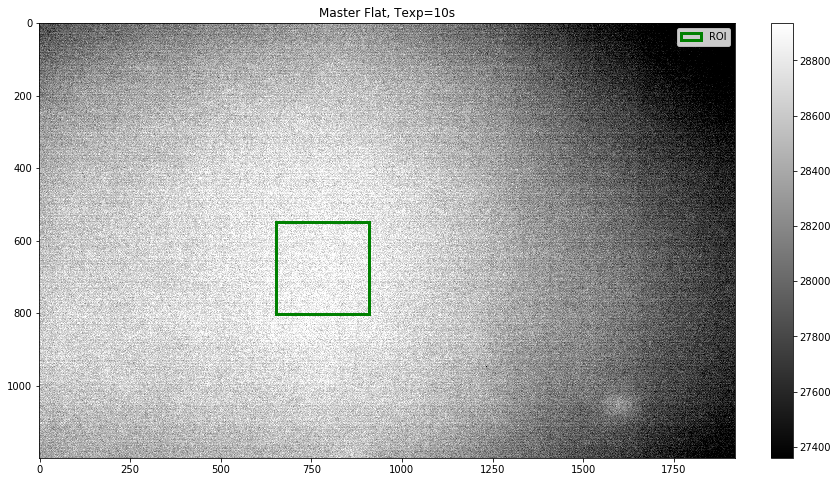

In [13]:
# Shows a flat image and Region of Interest (ROI)

roi_position = (652, 548)
roi_size = (256, 256)

with fits.open(master_flats.files_filtered(exposure=10)[0]) as hdu:
    a_master_flat = hdu[0].data

fig, ax = plt.subplots(figsize=(16, 8))
norm = ImageNormalize(a_master_flat, interval=PercentileInterval(95), stretch=LinearStretch())
im = ax.imshow(a_master_flat, cmap='gray', norm=norm)
rect = patches.Rectangle(roi_position, roi_size[0], roi_size[1], linewidth=3, edgecolor='g', facecolor='none')
ax.add_patch(rect)
ax.set_title('Master Flat, Texp=10s')
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.legend(['ROI'])

In [14]:
# Intensity is calculated as the average value of a ROI of 256x256 píxels in the most uniform área of the image.

flat_roi_avg = []

for exp_time in sorted(texp_flats):                                # For each exposure time
    
    filename = master_flats.files_filtered(exposure=exp_time)[0]   # Gets file name

    with fits.open(filename) as hdu:                               # Open fit file
        a_master_flat = hdu[0].data
            
    roi = Cutout2D(a_master_flat, roi_position, roi_size, copy = True)  # ROI 256 x 256 pixels image
    flat_roi_avg.append(np.average(roi.data))                           # Caculates average value of ROI

In [15]:
# Mean value computation for Bias (for completness only)

bias_avg = []

filename = masters.files_filtered(imagetyp = 'Bias Frame', include_path=True) [0]   # Gets file name

with fits.open(filename) as hdu:                               # Open bias file
    a_master = hdu[0].data

bias_avg.append(np.average(a_master))                         # Caculates average value of ROI
print('Bias mean value = ', bias_avg)

Bias mean value =  [807.1134409722222]


In [16]:
# Mean value computation for dark (for completness only)

dark_avg = []

texp_dark = sorted(masters.filter(imagetyp = 'Dark Frame').values('exptime', unique=True))

for exp_time in sorted(texp_dark):                                # For each exposure time
    
    filename = masters.files_filtered(imagetyp = 'Dark Frame', exposure=exp_time, include_path=True) [0]   # Gets file name

    with fits.open(filename) as hdu:                               # Open fit file
        a_master = hdu[0].data
            
    dark_avg.append(np.average(a_master))
    
print('Master darks exposure times:', texp_dark)
print('Dark mean value = ', dark_avg)

Master darks exposure times: [1.0, 10.0, 20.0]
Dark mean value =  [3.3561944444444443, 8.430534722222223, 13.920649305555555]


In [17]:
# Fitting line to measured data
slope, intercept, r, _, _ = stats.linregress(texp_flats, flat_roi_avg)
p1 = [slope, intercept]
y1 = np.polyval(p1,texp_flats)
print('* Slope =',slope)
print('* Intercept =',intercept)
print('* R^2 =',r)

* Slope = 2819.31851955184
* Intercept = 250.82171246885264
* R^2 = 0.9999320155588005


In [18]:
# Residuals analysis
res = 100* (y1 - flat_roi_avg) / y1  
std = np.std(res)
res_flag =  res < std
print ('Residuos = ', res)
print ('STD residuos = ', std)
print ('Resuidos menores a STD = ', res_flag)

Residuos =  [ 9.85619567e+01  9.01073826e+01  4.66333084e+01  1.37236365e+01
  6.42186469e+00  2.31446704e+00  1.08742691e+00 -9.24470385e-02
 -2.70862407e-01 -7.67289067e-01 -7.38744501e-01 -1.10716381e+00
 -9.75645545e-01 -1.20280531e+00 -9.06900628e-01 -1.03833584e+00
 -6.78567987e-01 -7.66768963e-01 -3.19480350e-01 -4.13084245e-01
 -1.59778414e-01 -9.60472392e-02  1.07216015e-01  2.02878829e-01
  4.28584276e-01  5.76976637e-01  9.56304994e-01]
STD residuos =  25.75514824892273
Resuidos menores a STD =  [False False False  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True]


In [19]:
# Values with residuals larger that STD are discarted and linear regresion is coputed again

texp_flats_filtered = list(compress(texp_flats,res_flag))
flat_roi_avg_filtered = list(compress(flat_roi_avg,res_flag))

slope, intercept, r, p_value, std_err = stats.linregress(texp_flats_filtered, flat_roi_avg_filtered)
p2 = [slope, intercept]
y2 = np.polyval(p2,texp_flats)
print('* Slope =',slope)
print('* Intercept =',intercept)
print('* R^2 =',r) 

* Slope = 2811.756424998751
* Intercept = 369.18697668675304
* R^2 = 0.999925866597946


In [20]:
df = pd.DataFrame(data={'T_exp': texp_flats, 'Measured':flat_roi_avg})
#df

In [21]:
# Values given by linear regresion are the expected levels
df.insert(2,'Expected',y2)

In [22]:
# Absolute Error
df['Error'] = df['Measured']-df['Expected']
# Percentage error
df['% Error'] = np.abs(100* df['Error']/df['Expected'])
# Magnitude error
df['Mag. Error'] = np.abs(2.5*np.log10(df['% Error']/100+1))
df

T_exp      Measured      Expected       Error    % Error  Mag. Error
0    0.001      3.647468    371.998733 -368.351265  99.019495    0.747239
1    0.010     27.601876    397.304541 -369.702665  93.052716    0.714190
2    0.100    284.312952    650.362619 -366.049668  56.283934    0.484786
3    0.500   1432.602600   1775.065189 -342.462589  19.292958    0.191537
4    1.000   2872.979980   3180.943402 -307.963421   9.681512    0.100334
5    2.000   5753.149170   5992.699827 -239.550657   3.997375    0.042556
6    3.000   8614.075684   8804.456252 -190.380568   2.162321    0.023227
7    4.000  11538.753174  11616.212677  -77.459503   0.666822    0.007216
8    5.000  14386.276062  14427.969102  -41.693040   0.288974    0.003133
9    6.000  17298.451294  17239.725527   58.725767   0.340642    0.003692
10   7.000  20133.697205  20051.481952   82.215253   0.410021    0.004443
11   8.000  23057.862671  22863.238377  194.624294   0.851254    0.009203
12   9.000  25874.694519  25674.994802  199.699717   0.777798    0.008412
13  10.000  28786.132935  28486.751227  299.381708   1.050951    0.011351
14  11.000  31546.852722  31298.507652  248.345070   0.793473    0.008581
15  12.000  34436.536255  34110.264077  326.272178   0.956522    0.010336
16  13.000  37152.367371  36922.020502  230.346869   0.623874    0.006753
17  14.000  40025.851440  39733.776927  292.074514   0.735079    0.007952
18  15.000  42676.508362  42545.533352  130.975010   0.307847    0.003337
19  16.000  45547.292700  45357.289777  190.002924   0.418903    0.004539
20  17.000  48256.216565  48169.046202   87.170363   0.180968    0.001963
21  18.000  51047.537769  50980.802627   66.735142   0.130902    0.001420
22  19.000  53760.172205  53792.559052  -32.386847   0.060207    0.000653
23  20.000  56522.287231  56604.315477  -82.028245   0.144915    0.001572
24  21.000  59201.689368  59416.071902 -214.382534   0.360816    0.003910
25  22.000  61916.512158  62227.828327 -311.316168   0.500284    0.005418
26  23.000  64472.639514  65039.584752 -566.945237   0.871693    0.009423

## 5. Gráficos

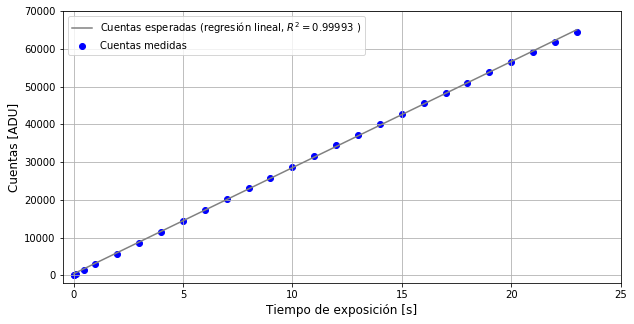

In [23]:
#
fig, ax = plt.subplots(figsize=(10, 5))
plt.scatter(df['T_exp'],df['Measured'], color = 'b', label = 'Cuentas medidas')
plt.plot(df['T_exp'],df['Expected'],'gray', label = r'Cuentas esperadas (regresión lineal, $R^2 = %.5f $ )' %r)
plt.xlim([-0.5, 25])
plt.ylim([-2000, 70000])
plt.xlabel("Tiempo de exposición [s]", fontsize=12)
plt.ylabel("Cuentas [ADU]", fontsize=12)
plt.legend()
plt.grid()

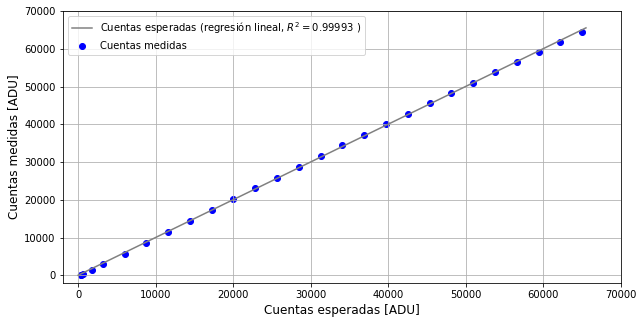

In [24]:
#
fig, ax = plt.subplots(figsize=(10, 5))
plt.scatter(df['Expected'],df['Measured'], color = 'b', label = 'Cuentas medidas')
plt.plot([0, 65535],[0, 65535],'gray', label = r'Cuentas esperadas (regresión lineal, $R^2 = %.5f $ )' %r)
plt.xlim([-2000, 70000])
plt.ylim([-2000, 70000])
plt.xlabel("Cuentas esperadas [ADU]", fontsize=12)
plt.ylabel("Cuentas medidas [ADU]", fontsize=12)
plt.legend()
plt.grid()

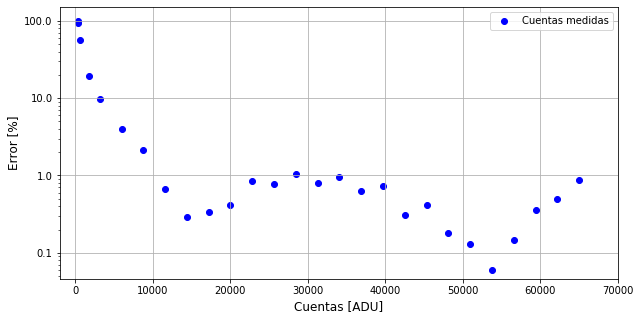

In [25]:
#
ylim1 = 100* (10**(0.0005/2.5) - 1)
ylim2 = 100* (10**(1     /2.5) - 1)

fig, ax = plt.subplots(figsize=(10, 5))
plt.scatter(df['Expected'],df['% Error'], color = 'b', label = 'Cuentas medidas')
plt.xlim([-2000, 70000])
plt.ylim([ylim1, ylim2])
plt.xlabel("Cuentas [ADU]", fontsize=12)
plt.ylabel("Error [%]", fontsize=12)
ax.set_yscale('log')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))
ax.yaxis.set_minor_formatter(NullFormatter())
plt.legend()
plt.grid()

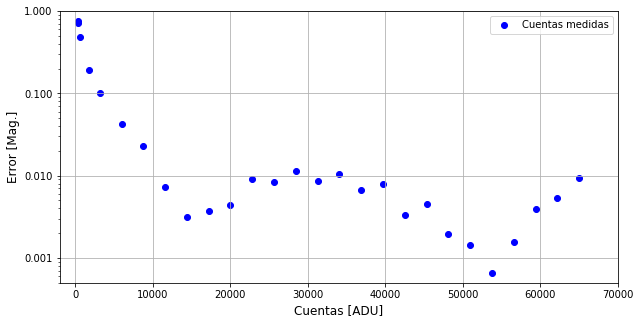

In [26]:
#
lylim1 = 2.5*np.log10(1+ylim1/100)
lylim2 = 2.5*np.log10(1+ylim2/100)

fig, ax = plt.subplots(figsize=(10, 5))
plt.scatter(df['Expected'],df['Mag. Error'], color = 'b')
plt.xlim([-2000, 70000])
plt.ylim([lylim1, lylim2])
plt.xlabel("Cuentas [ADU]", fontsize=12)
plt.ylabel("Error [Mag.]", fontsize=12)
ax.set_yscale('log')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.3f}'))
ax.yaxis.set_minor_formatter(NullFormatter())
plt.legend(['Cuentas medidas'])
plt.grid()

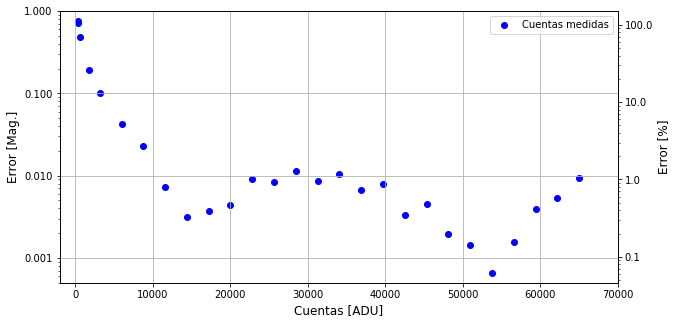

In [27]:
#
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(df['Expected'],df['Mag. Error'], color = 'b', label = 'Cuentas medidas')
ax.set_xlim(-2000, 70000)
plt.ylabel("Error [Mag.]", fontsize=12)

ax.set_ylim(lylim1, lylim2)
plt.legend()
plt.xlabel("Cuentas [ADU]", fontsize=12)
ax.set_yscale('log')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.3f}'))
ax.yaxis.set_minor_formatter(NullFormatter())
ax.grid(True)

ax2 = ax.twinx()
ax2.set_ylim(ylim1, ylim2)
ax2.set_ylabel(r"Error [%]", fontsize=12)
ax2.set_yscale('log')
ax2.yaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))
ax2.yaxis.set_minor_formatter(NullFormatter())
ax2.grid(False)
